In [4]:
# Preparation with environment for notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Allow inline matplotlib figures appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Preprocessing and Loading of dataset

In [106]:
from NeuralNetwork.neural_network import *
from NeuralNetwork.data_utils import *
import time

mnistDir = "NeuralNetwork/MnistData"
(batchSize, testSize, valSize)=(300, 10000, 0)
datasets = getMnistDataSets(mnistDir,valSize=valSize)
train = datasets['train']
test = datasets['test']
if valSize != 0:
    validation = datasets['validation']
else: 
    validation = None
    
Xte, Yte = test.nextBatch(testSize)


# Initialize Parameters
hiddenLayer = [300]
classNum = 10 
epsilon= 0.0001 
network = NeuralNetwork(train, validation, classNum, hiddenLayer, epsilon, batchSize=batchSize, valSize=valSize)

weightConsWeight = 0.001
activConsWeight = 0.001
growingStep = 10
iterOutNum =200
iterInNum = 3
hasLambda = True
calLoss = True

# Train 
tic = time.time()
network.trainWithMiniBatch(weightConsWeight, activConsWeight, growingStep, 
                           iterOutNum, iterInNum, hasLambda, calLoss=calLoss, 
                           lossType='smx', minMethod='prox', tau=1, ite=10, 
                           regWeight=1, dampWeight=0.0, evaluate=True)


toc = time.time()
print 'Total training time: %fs' % (toc - tic)

# Predictf
Ypred,z = network.predict(Xte)
print ',,,',Ypred.shape
print 'Prediction accuracy: %f' %np.mean(Ypred == Yte)

Initializing a neural network with :  1  hidden layers, hidden layer dimension: [300]
Outiter 0 eval loss(global): 0.989760
Outiter 20 eval loss(global): 0.536179
Outiter 40 eval loss(global): 0.473846
Outiter 60 eval loss(global): 0.447832
Outiter 80 eval loss(global): 0.427425
Outiter 100 eval loss(global): 0.406503
Outiter 120 eval loss(global): 0.396234
Outiter 140 eval loss(global): 0.382181
Outiter 160 eval loss(global): 0.375587
Outiter 180 eval loss(global): 0.377510
Start round # 1
Final global loss:  0.407804
Total training time: 96.425274s
,,, (10000,)
Prediction accuracy: 0.882300


## Check loss with tensorflow

In [107]:
import tensorflow as tf
def preprocess(X):
    
#     # return X
#     X = X.astype(np.float64)
#     # Mean subtraction
#     X -= np.mean(X)  
#     # Normalization
   # X /= np.std(X, axis = 0)
    return X

def calLossWithTF(Y_tr, logits):
    with tf.Graph().as_default() as g:
        sess = tf.InteractiveSession()
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits, np.int64(Y_tr), name='xentropy')
        loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    return sess.run(loss)

w = network.W
ypred, z = network.predictByFeed(train.images,w)
print 'Prediction accuracy: %f' %np.mean(ypred == train.labels)

lossTF = calLossWithTF(train.labels, z.T)
print 'Loss from TF:', lossTF

# print network.softMaxLossTest(w)
# print network.validate(w, 'smx', dataType='train')


Prediction accuracy: 0.876367
Loss from TF: 0.407803780909


## Visualisation

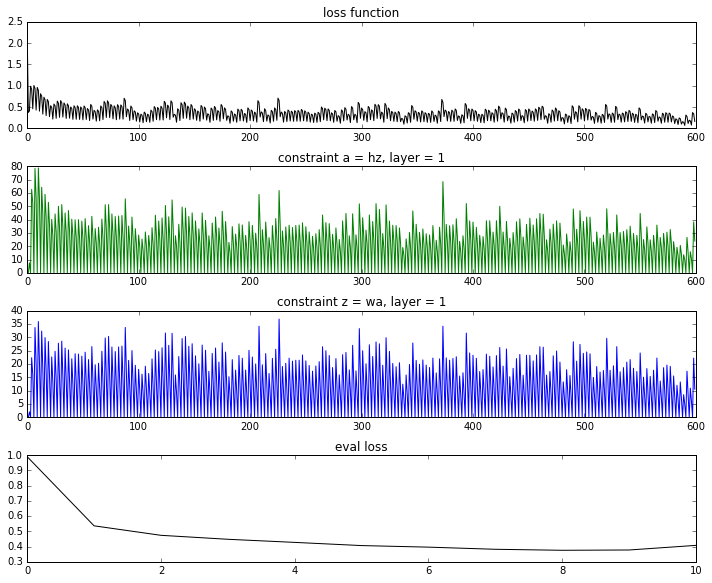

In [108]:
L = len(hiddenLayer)
if calLoss:
    fig = plt.figure()
    gs = gridspec.GridSpec(5,L)

    dataLoss = fig.add_subplot(gs[0,:])
    dataLoss.set_title('loss function')
    dataLoss.plot(network.dataLoss, 'k-')
    
    for l in range(0,L):
        aloss = fig.add_subplot(gs[1,l])
        aloss.set_title('constraint a = hz, layer = %d' % (l+1))
        aloss.plot(network.aConstrLoss[l], 'g-')
        #print network.aConstrLoss[l]

        zloss = fig.add_subplot(gs[2,l])
        zloss.set_title('constraint z = wa, layer = %d' % (l+1))
        zloss.plot(network.zConstrLoss[l], 'b-')

#             lag = fig.add_subplot(gs[3,:])
#             lag.set_title('lagrange term')
#             lag.plot(network.lagraLoss, 'r-')

        evaLoss = fig.add_subplot(gs[3,:])
        evaLoss.set_title('eval loss')
        evaLoss.plot(network.evalLoss, 'k-')
    
#     zLLoss = fig.add_subplot(gs[3,:])
#     zLLoss.set_title('output layer zL')
#     zLLoss.plot(network.evalLoss, 'k-')

#     total = fig.add_subplot(gs[4,:])
#     total.set_title('total loss ')
#     total.plot(network.totalLoss, 'r-')

    plt.tight_layout()
    plt.show()